<center><img src="img/logo_hse_black.jpg"></center>

<h1><center>Data Analysis</center></h1>
<h3><center>Andrey Shestakov (<a href="mailto:avshestakov@hse.ru">avshestakov@hse.ru</a>)</center></h3>
<hr>
<h2><center>Feature Selection and Dimention Reduction. PCA.<sup><a href="#fn1" id="ref1">1</a></sup></center></h2>



<sup id="fn1">1. Some materials are taken from <a href="http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B0%D1%82%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_%D1%80%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F_%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2_%28%D0%BA%D1%83%D1%80%D1%81_%D0%BB%D0%B5%D0%BA%D1%86%D0%B8%D0%B9%2C_%D0%92.%D0%92.%D0%9A%D0%B8%D1%82%D0%BE%D0%B2%29">machine learning course of Victor Kitov</a></sup>

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import seaborn as sns

plt.style.use('seaborn-talk')
plt.rcParams['figure.figsize'] = (16,10)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

from ipywidgets import interact, IntSlider, fixed, FloatSlider
    
import warnings
warnings.filterwarnings('ignore')

## Feature Selection vs. Dimension Reduction

<center><img src='img/sel_extr.png' width=600></center>

* Feature selection is a process of selecting a subset of original features with minimum loss of information related to final task (classification, regression, etc.)
* Dimension reduction is a result of some transformation of initial features to (possibly) lower dimension feature space

## Why feature selection?

* increase predictive accuracy of classifier
* improve optimization stability by removing multicollinearity
* increase computational efficiency
* reduce cost of future data collection
* make classifier more interpretable

**Not always necessary step**
* some methods have implicit feature selection


## Feature Selection Approaches
* Unsupervised methods
    * don't use target feature
* Filter methdos
    * use target feature
    * consider each feature independently
* Wrapper methods
    * uses model quality
* Embedded methdos
    * embedded inside model

### "Unsupervised" methods

* Determine feature importance regardless of target feature
* Your ideas?

### Filter methods 
* Features are considered independently of each other
* Individual predictive power is measures

**Basically**
* Order features with respect to feature importances $I(f)$:
$$
I(f_{1})> I(f_{2})> \dots\ge I(f_{D})
$$
* Select top $m$
$$
\hat{F}=\{f_{1},f_{2},...f_{m}\}
$$


* Simple to implement
* Usually quite fast
* When features are correlated, it will take many redundant features

#### Examples

* Correlation
    * Which kind of relationship does correlation measure?
* Mutual Information
    * Entropy of variable $Y$: $H(Y) = - \sum_y p(y)\ln p(y)$
    * Conditional entropy of $Y$ after observing $X$: $H(y|x) = - \sum_x p(x) \sum_y p(y|x)\ln p(y|x) $
    * Mutial information: $$MI(Y, X) = \sum_{x,y} p(x,y) \ln\left[\frac{p(x,y)}{p(x)p(y)}\right]$$
        * Mutual information measures how much $X$ and $Y$ share information between each other
        * $MI(Y,X) = H(Y) - H(Y|X)$

<center><img src='img/mi.png' width=300></center>

In [3]:
df_titanic = pd.read_csv('data/titanic.csv')
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
P = pd.crosstab(df_titanic.Survived, df_titanic.Sex, normalize=True).values
print(P)

[[0.09090909 0.52525253]
 [0.26150393 0.12233446]]


In [5]:
px = P.sum(axis=1)[:, np.newaxis]
py = P.sum(axis=0)[:, np.newaxis]
print(px)
print(py)

[[0.61616162]
 [0.38383838]]
[[0.35241302]
 [0.64758698]]


In [6]:
px.dot(py.T)

array([[0.21714338, 0.39901824],
       [0.13526964, 0.24856874]])

In [7]:
def mutual_info(x, y):
    '''
    Method should take arrays of values x and y and calculate their mutual information
    '''
    Pxy = pd.crosstab(x, y, normalize=True).values
    Px  = Pxy.sum(axis=1)[:, np.newaxis]
    Py = Pxy.sum(axis=0)[:, np.newaxis]
    PxPy = Px.dot(Py.T)
    MI = (Pxy*np.log(Pxy/(PxPy))).sum()
    
    return MI

In [8]:
mutual_info(df_titanic.Pclass, df_titanic.Survived)

0.05810725269032348

### Wrapper methods
* Selecting suboptimal subset of features
* Could be slow
* Examples: 
    * Recursive Feature Elimination
        * Consider full set of features
        * Fit a model, measure feature importance (based on model)
        * Remove least important feature(s)
        * Repeat
    * [Boruta Algorithm](https://www.google.ru/url?sa=t&rct=j&q=&esrc=s&source=web&cd=2&ved=0ahUKEwif5biy-fTWAhXkYJoKHbdxCLAQFgg2MAE&url=https%3A%2F%2Fwww.jstatsoft.org%2Farticle%2Fview%2Fv036i11%2Fv36i11.pdf&usg=AOvVaw3tyiHN0BCe2fkkAA6xEVDE)

<center><img src='img/rfecv.png' width=700></center>

### Embedded methods
* Feature selection process in included in the model
* Examples:
    * Decision Trees
    * Linear model with L1 regularization

## Something different: permutation importance

* Train your model
* Calculate quality measure on validation set
* For each feature:
    * replace given values with random values from the same distribution
    * ... or perform random shuffling
    * observe the difference in quality measure

<center><img src='https://blog.socratesk.com/assets/img/rand_shuffle.png'></center>

# Dimension Reduction
# Principal Component Analysis (PCA)

## Feature Selection vs. Feature Extraction


<center><img src='img/sel_extr.png' width=600></center>

## Why dimension reduction?

same as in feature selection +
* data visualization


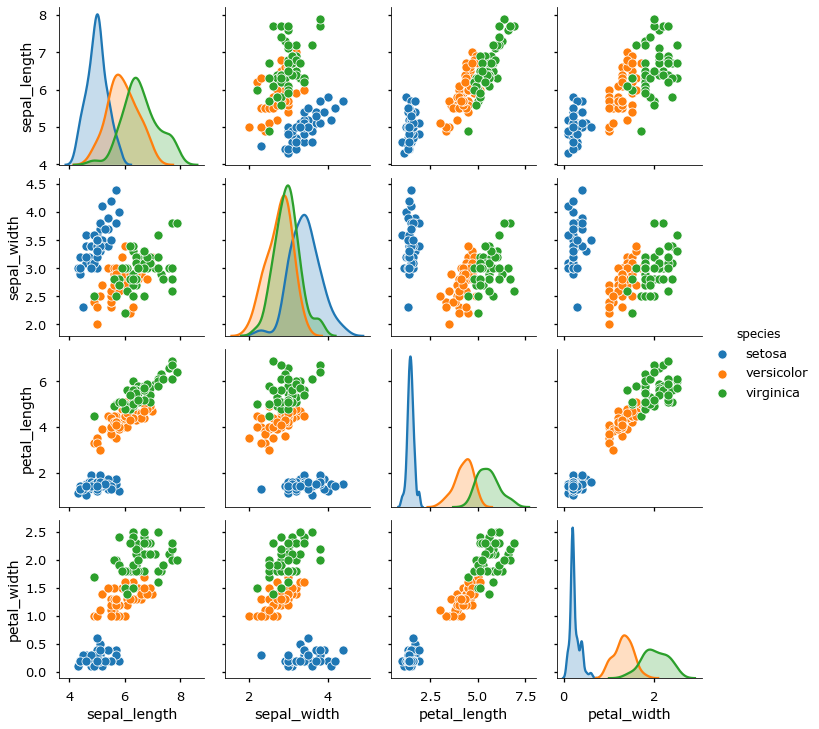

In [9]:
iris = sns.load_dataset('iris')
sns.pairplot(iris, hue='species')

In [10]:
X = iris.iloc[:, :4].values

mapping = dict((s, i) for i, s in enumerate(iris.species.unique()))
y = iris.species.replace(mapping).values

from sklearn.decomposition import PCA


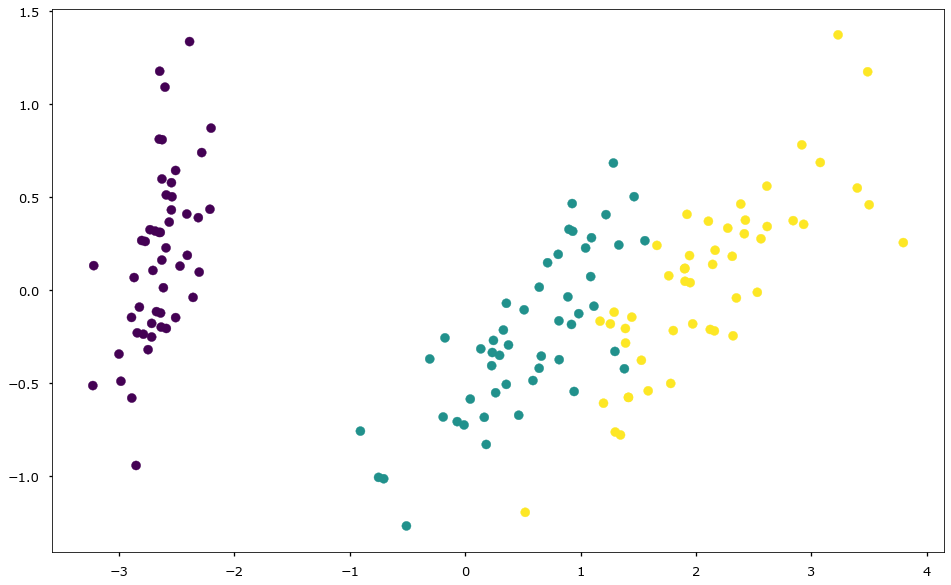

In [11]:
# Перейдем от 4 признаков к 2 компонентам
pca = PCA(n_components=2, random_state=123)
pca.fit(X) # Никакого "y"
PC = pca.transform(X)
plt.scatter(PC[:,0], PC[:,1],c=y)

<center><img src='http://lvdmaaten.github.io/tsne/examples/mnist_tsne.jpg' width=500></center>

# PCA

* Intuition 1: Find directions along which our datapoints have the greatest variance

<center><img src='http://www.visiondummy.com/wp-content/uploads/2014/05/correlated_2d.png' width=400></center>

<center><img src='img/pca.png' width=800></center>

# PCA

* Intuition 2: Find a subspace $L$ (of lesser dimention) s.t. the sum of squares of differences between points and their projections is minimized

<center><img src='img/plane_best_fit.png' width=500></center>


# PCA

* Intuition 2: Find a subspace $L$ (of lesser dimention) s.t. the sum of squares of differences between points and their projections is minimized

<center><img src='img/pca_example.png' width=800></center>

## In other words, we can consider PCA as

* A transformation of your inital feature axes ...
    * New axes are just a linear combination of initial axes
    * New axes are orthogonal (orthonormal) to each other
    * Variance of data across those axes is maximized
* ... which keeps only the most "informative" axes

## How do we project data on new axes?

* Consider an object $x$ with 3 features: $x=(-0.343, -0.754, 0.241)$
* We can say that it is spanned on 3 basis vectors of our feature space:
$$ e_1 = \left( \begin{array}{c}
1 \\
0 \\
0
\end{array} \right) \quad
e_2 = \left( \begin{array}{c}
0 \\
1 \\
0
\end{array} \right) \quad
e_3 = \left( \begin{array}{c}
0 \\
0 \\
1
\end{array} \right) \quad$$

$$ x = -0.343 e_1 + -0.754 e_2 + 0.241 e_3 $$

* Consider new basis vectors:

$$ a_1 = \left( \begin{array}{c}
-0.390 \\
0.089 \\
-0.916
\end{array} \right) \quad
a_2 = \left( \begin{array}{c}
-0.639 \\
-0.742 \\
0.200
\end{array} \right) \quad
a_3 = \left( \begin{array}{c}
-0.663 \\
0.664 \\
0.346
\end{array} \right) \quad$$
* How do we project $x$ on it?


## Projecting

$$ a_1 = \left( \begin{array}{c}
-0.390 \\
0.089 \\
-0.916
\end{array} \right) \quad
a_2 = \left( \begin{array}{c}
-0.639 \\
-0.742 \\
0.200
\end{array} \right) \quad
a_3 = \left( \begin{array}{c}
-0.663 \\
0.664 \\
0.346
\end{array} \right) \quad$$


$$ z = A^\top x = \left( \begin{array}{ccc}
-0.390 & 0.089 & -0.916\\
-0.639 & -0.742 & 0.200 \\
-0.663 & 0.664 & 0.346
\end{array} \right)
\left( \begin{array}{c}
-0.343 \\
-0.754 \\
0.241
\end{array} \right) = 
\left( \begin{array}{c}
-1.154 \\
0.828 \\
0.190
\end{array} \right)$$

That is: 
$$ z = -1.154 a_1 + 0.828 a_2 + 0.190 a_3$$

(Example from [Mohammed J. Zaki, Ch7](https://www.amazon.com/Data-Mining-Analysis-Fundamental-Algorithms/dp/0521766338) )

* So how do we find those $a_i$?
    * Orthonormality
    * Maximize variance
* Vectors $a_i$ are called principal components

# Construction of PCA

## Construction of PCA

* Principal components $a_{1},a_{2},...a_{D}\in\mathbb{R}^{D}$ are orthonormal: $$\langle a_{i},a_{j}\rangle=\begin{cases}
1, & i=j\\
0 & i\ne j
\end{cases}$$
* Maximize variance
    * Datapoints in $X$ assumed to be centered (and scaled)
    * $z_i = a^\top x_i$ - projection of $x_i$ on $a$
    * Variance across principal component $a$ for dataset
    $$
    \begin{align} \sigma^2_a & = \frac{1}{n}\sum\limits_{i=1}^n(z_i - \mu_z)^2 \\
    & = \frac{1}{n}\sum\limits_{i=1}^n(a^\top x_i)^2 \\
    & = \frac{1}{n}\sum\limits_{i=1}^n a^\top( x_i x_i^\top) a \\
    & = a^\top \left(\frac{1}{n}\sum\limits_{i=1}^n x_i x_i^\top \right) a \\
    & = a^\top X^\top X a \\
    & = a^\top C a \rightarrow \max_a \\
    \end{align}
    $$
    * $C = X^\top X$ - convariance (correlation in case of scaled dataset) matrix

## Covariance matrix reminder

* Given $N$ observations of variables $x$ and $y$, covariace is calculated as
$${s}_{xy}=\mathrm {cov} (x,y)={1 \over N}\sum _{n=1}^{N}\left(x_{n}-{\overline {x}}\right)\left(y_{n}-{\overline {y}}\right)$$
* scaled measure of linear dependency between $x$ and $y$

Relationship with variance and correlation:
* $\mathrm {cov} (x,x) = \mathrm {var} (x)$

* $\mathrm {corr} (x,y)=\frac{\mathrm {cov} (x,y)}{\mathrm {var} (x)\mathrm {var} (y)}$

## Covariance matrix reminder

* If $X$ is feature matrix (features are on columns) we can calculate covariance matrix:
$$\operatorname {cov} (X ) ={\begin{bmatrix}\mathrm {var}(x_1)&\mathrm {cov} (x_1,x_2)&\cdots &\mathrm {cov} (x_1,x_d)\\\\\mathrm {cov} (x_2,x_1)&\mathrm {var}(x_2)&\cdots &\mathrm {cov} (x_2,x_d)\\\\\vdots &\vdots &\ddots &\vdots \\\\\mathrm {cov} (x_d,x_1)&\mathrm {cov} (x_d,x_2)&\cdots &\mathrm {var}(x_d)\end{bmatrix}}$$

Examples of data distributions and corresponding covariances
<center><img src='https://cookierobotics.com/007/example_same_diagonals.png'></center>

## Useful properties of $X^\top X$

* $X^\top X$ - symmetric and positive semi-definite
    * $(X^\top X)^\top = X^\top X$
    * $\forall w \in \mathbb{R}^D:\ w^\top (X^\top X) w \geq 0$
* Properties
    * All eigenvalues $\lambda_i \in \mathbb{R}, \lambda_i \geq 0$ (we also assume $\lambda_1 \geq \lambda_2  \geq \dots \geq \lambda_d $)
    * Eigenvectors for $\lambda_i \neq \lambda_j $ are orthogonal: $v_i^\top v_j = 0$
    * For each unique eigenvalue $\lambda_i$ there is a unique $v_i$

## Construction of PCA


1. $a_{1}$ is selected to maximize $a_1^\top X^\top X a_1$
subject to $\langle a_{1},a_{1}\rangle=1$
2. $a_{2}$ is selected to maximize $a_2^\top X^\top X a_2$
subject to $\langle a_{2},a_{2}\rangle=1$, $\langle a_{2},a_{1}\rangle=0$
3. $a_{3}$ is selected to maximize $a_3^\top X^\top X a_3$
subject to $\langle a_{3},a_{3}\rangle=1$, $\langle a_{3},a_{1}\rangle=\langle a_{3},a_{2}\rangle=0$


etc.

## Derivation of 1st component
$$
\begin{equation}
\begin{cases}
a_1^\top X^\top X a_1 \rightarrow \max_{a_1} \\
a_1^\top a_1 = 1
\end{cases}
\end{equation}
$$
* Lagrangian of optimization problem
$$ \mathcal{L}(a_1, \nu) = a_1^\top X^\top X a_1 - \nu (a_1^\top a_1 - 1) \rightarrow max_{a_1, \nu}$$
* Derivative w.r.t. $a_1$
$$ \frac{\partial\mathcal{L}}{\partial a_1} = 2X^\top X a_1 - 2\nu a_1 = 0 $$
* so $a_1$ is selected from a set of eigenvectors of  $X^\top X$. But which one?

## Back to component 1

Initially, our objective was 
$$a_1^\top X^\top X a_1  \rightarrow \max_{a_1}$$

From lagrangian we derived that 
$$X^\top X a_1 = \nu a_1$$

Putting one in to another:
$$ a_1^\top X^\top X a_1 = \nu a_1^\top a_1 = \nu \rightarrow \max$$

That means:
* $\nu$ should be the greatest eigenvalue of matrix $X^\top X$, which is $\lambda_1$
* $a_1$ is eigenvector, correspondent to $\lambda_1$

## Derivation of 2nd component
$$
\begin{equation}
\begin{cases}
a_2^\top X^\top X a_2 \rightarrow \max_{a_2} \\
a_2^\top a_2 = 1 \\
a_2^\top a_1 = 0
\end{cases}
\end{equation}
$$
* Lagrangian of optimization problem
$$ \mathcal{L}(a_2, \nu,\alpha) = a_2^\top X^\top X a_2 - \nu (a_2^\top a_2 - 1) - \alpha (a_1^\top a_2) \rightarrow max_{a_2, \nu,\alpha}$$
* Derivative w.r.t. $a_2$
$$ \frac{\partial\mathcal{L}}{\partial a_2} = 2X^\top X a_2 - 2\nu a_2 - \alpha a_1 = 0 $$

## Derivation of 2nd component
* By multiplying by $a_1^\top$ :
$$ a_1^\top\frac{\partial\mathcal{L}}{\partial a_2} = 2a_1^\top X^\top X a_2 - 2\nu a_1^\top a_2 - \alpha a_1^\top a_1 = 0 $$

* It follows that $\alpha a_1^\top a_1 = \alpha = 0$, which means that 
$$ \frac{\partial\mathcal{L}}{\partial a_2} = 2X^\top X a_2 - \nu a_2 = 0 $$
And $a_2$ is selected from a set of eigenvectors of $X^\top X$. Again, which one?

Derivations of other components proceeds in the same manner

## PCA algorithm

1. Center (and scale) dataset
2. Calculate covariance matrix $С=X^\top X$
3. Find first $k$ eigenvalues and eigenvectors
$$A = 
\left[
  \begin{array}{cccc}
    \mid & \mid & & \mid\\
    a_{1} & a_{2} & \ldots & a_{k} \\
    \mid & \mid & & \mid 
  \end{array}
\right]
$$
4. Perform projection:
$$ Z = XA $$ 

## Explained variance or why do we neeed $\lambda$?

* As we remember
$$a_i^\top X^\top X a_i = \lambda_i,$$
which means that $\lambda_i$ shows variance of data "explained" by $a_i$
* We can calculate explained variance ratio for $a_i$:
$$
\frac{\lambda_{i}}{\sum_{d=1}^{D}\lambda_{d}}
$$

<center><img src='img/cumul_rat.png' width=1900></center>

# (Supplementary) alternative view on PCA

## Best hyperplane fit

For point $x$ and subspace $L$ denote: 

* $p$: the projection of $x$ on $L$ 
* $h$: orthogonal complement 
* $x=p+h$, $\langle p,h\rangle=0$, 

#### Proposition
$\|x\|^2 = \|p\|^2 + \|h\|^2$

For training set $x_{1},x_{2},...x_{N}$ and subspace $L$  we can find:

* projections: $p_{1},p_{2},...p_{N}$
* orthogonal complements: $h_{1},h_{2},...h_{N}$.

## Example: line of best fit

* In PCA the sum of squared perpendicular distances to line is minimized:

<center><img src='img/line_best_fit.png' width=500></center>

## Example: plane of best fit

<center><img src='img/plane_best_fit.png' width=500></center>


## Best subspace fit
#### Definition
Best-fit $k$-dimentional subspace for a set of points $x_1 \dots x_N$ is a subspace, spanned by $k$ vectors $a_1$, $a_2$, $\dots$, $a_k$, solving

$$ \sum_{n=1}^N \| h_n \| ^2 \rightarrow \min\limits_{a_1, a_2,\dots,a_k}$$

or

$$ \sum_{n=1}^N \| p_n \| ^2 \rightarrow \max\limits_{a_1, a_2,\dots,a_k}$$

## Definition of PCA

Principal components $a_1, a_2, \dots, a_k$ are vectors, forming orthonormal basis in the k-dimentional subspace of best fit

#### Properties
* Not invariant to translation:
    * center data before PCA: 
$$
x\leftarrow x-\mu\text{ where }\mu=\frac{1}{N}\sum_{n=1}^{N}x_{n}
$$
* Not invariant to scaling:
    * scale features to have unit variance before PCA


# Construction of PCA

## Construction of PCA

* Datapoints in $X$ assumed to be centralized and scaled (!)
* Principal components $a_{1},a_{2},...a_{D}\in\mathbb{R}^{D}$ are
found such that $\langle a_{i},a_{j}\rangle=\begin{cases}
1, & i=j\\
0 & i\ne j
\end{cases}$
* $Xa_{i}$ is a vector of projections of all objects onto the $i$-th principal component.
* For any object $x$ its projections onto principal components are
equal to:
$$
p=A^{T}x=[\langle a_{1},x\rangle,...\langle a_{D},x\rangle]^{T}
$$
where $A=[a_{1};a_{2};...a_{D}]\in\mathbb{R}^{DxD}$.

## Construction of PCA


1. $a_{1}$ is selected to maximize $\left\lVert Xa_{1}\right\rVert $
subject to $\langle a_{1},a_{1}\rangle=1$
2. $a_{2}$ is selected to maximize $\left\lVert Xa_{2}\right\rVert $
subject to $\langle a_{2},a_{2}\rangle=1$, $\langle a_{2},a_{1}\rangle=0$
3. $a_{3}$ is selected to maximize $\left\lVert Xa_{3}\right\rVert $
subject to $\langle a_{3},a_{3}\rangle=1$, $\langle a_{3},a_{1}\rangle=\langle a_{3},a_{2}\rangle=0$


etc.

## PCA summary

* Dimensionality reduction - common preprocessing step for efficiency and numerical stability.
* Solution vectors $a_1,\dots,a_k$ are called top $k$ principal components.
* Principal component analysis - expression of $x$ in terms of first $k$ principal components.
* It is unsupervised linear dimensionality reduction.
* Solution is achieved on top $k$ eigenvectors $a_{1},...a_{k}$ of covariance matrix.

# References
* Mohammed J. Zaki - Data Mining and Analysis: Fundamental Concepts and Algorithms, Ch7 
* [Understanding covariance matrix](https://datascienceplus.com/understanding-the-covariance-matrix/)
* [PCA tutorial](https://www.cs.princeton.edu/picasso/mats/PCA-Tutorial-Intuition_jp.pdf)
* [PCA in python](https://sebastianraschka.com/Articles/2014_pca_step_by_step.html) - step by step